# CNN 구현

모델의 구조는 VGG를 토대로 mini VGG를 구현하였음.

In [1]:
import numpy as np

In [21]:
from sklearn.datasets import fetch_openml

# OpenML에서 MNIST 데이터셋 로드
# as_frame=False로 설정해 numpy array 형태로 바로 사용
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

# 입력 데이터
# 원본 픽셀 값은 [0, 255] 범위이므로 float32로 변환 후 정규화
# shape: (70000, 784)
X = mnist.data.astype(np.float32) / 255.0

# 정답 레이블
# 문자열 형태이므로 int64로 변환
y = mnist.target.astype(np.int64)

# CNN 입력 형태로 reshape
# (N, C, H, W) 형태를 맞추기 위함
# MNIST는 grayscale 이미지이므로 C = 1
X = X.reshape(-1, 1, 28, 28)

# 전체 데이터를 그대로 쓰기보다
# from-scratch CNN 검증을 위해 소량 샘플만 사용
# (연산량 감소 + 디버깅 용이)
np.random.seed(0)
idx = np.random.choice(len(X), 100, replace=False)

X = X[idx]
y = y[idx]

# 데이터 차원 확인
# CNN forward/backward에서 shape mismatch를 방지하기 위함
print("X:", X.shape)  # (100, 1, 28, 28)
print("y:", y.shape)  # (100,)

X: (100, 1, 28, 28)
y: (100,)


리스트로 모델의 구조를 다루고 싶다고 생각해서 리스트 안에 딕셔러니로 모델의 구조를 간단하게 바꿀 수 있도록 설계함

In [3]:
layers = [
    ("conv", {"filters": 16, "kernel": 3, "stride": 1, "pad": 1}),
    ("relu", {}),

    ("conv", {"filters": 16, "kernel": 3, "stride": 1, "pad": 1}),
    ("relu", {}),

    ("pool", {"size": 2, "stride": 2}),

    ("conv", {"filters": 32, "kernel": 3, "stride": 1, "pad": 1}),
    ("relu", {}),

    ("conv", {"filters": 32, "kernel": 3, "stride": 1, "pad": 1}),
    ("relu", {}),
    
    ("pool", {"size": 2, "stride": 2}),

    ("flatten", {}),

    ("fc", {"out_dim": 128}),
    ("relu", {}),

    ("fc", {"out_dim": 10})
]

In [ ]:
def initialize_parameters(X, layers):
    """
    X: 입력 데이터 (N, C, H, W)
    layers: 네트워크 설계도
            예) [("conv", {...}), ("pool", {...}), ("fc", {...})]
    """

    # 모든 레이어의 파라미터(W, b)를 저장할 딕셔너리
    parameters = {}

    # 입력 데이터 차원
    # N은 초기화에는 직접 쓰이지 않지만, 전체 구조 이해를 위해 같이 언패킹
    N, C, H, W = X.shape

    # conv, fc 레이어가 여러 개 있을 수 있으므로 인덱스 관리
    conv = 0
    fc = 0

    # FC 레이어 차원 추적용 변수
    # 첫 FC는 conv/pool 결과를 flatten한 크기에서 시작
    prev_dim = None

    # 레이어 설계도를 앞에서부터 하나씩 순회
    for layer_type, cfg in layers:

        # =============================
        # Conv 레이어 초기화
        # =============================
        if layer_type == "conv":
            # conv 설정값
            filters = cfg["filters"]   # 출력 채널 수
            kernel = cfg["kernel"]     # 커널 크기 (정사각형 가정)
            stride = cfg["stride"]
            pad = cfg["pad"]

            # fan_in = 한 필터가 바라보는 입력 뉴런 개수
            # (입력 채널 * 커널 높이 * 커널 너비)
            fan_in = C * kernel * kernel

            # He initialization
            # ReLU 계열 활성화 함수에서 분산 유지를 위해 사용
            # shape: (filters, C, kernel, kernel)
            w = np.random.randn(filters, C, kernel, kernel) * np.sqrt(2 / fan_in)

            # conv bias는 필터 개수만큼
            b = np.zeros(filters)

            # 파라미터 저장
            parameters[f"conv{conv}"] = {
                "W": w,
                "b": b
            }

            conv += 1

            # conv 연산 이후 feature map 크기 계산
            # forward에서 실제로 나올 출력 크기를 그대로 추적
            layer_h_out = (H + 2 * pad - kernel) // stride + 1
            layer_w_out = (W + 2 * pad - kernel) // stride + 1

            # 다음 레이어를 위한 상태 업데이트
            H = layer_h_out
            W = layer_w_out
            C = filters  # 출력 채널 수는 다음 입력 채널 수가 됨

        # =============================
        # Pool 레이어 (파라미터 없음)
        # =============================
        elif layer_type == "pool":
            poolsize = cfg["size"]
            stride = cfg["stride"]

            # pooling은 공간 크기만 줄이고 채널 수는 유지
            layer_h_out = (H - poolsize) // stride + 1
            layer_w_out = (W - poolsize) // stride + 1

            H = layer_h_out
            W = layer_w_out
            # C는 변하지 않음

        # =============================
        # Fully Connected 레이어 초기화
        # =============================
        elif layer_type == "fc":
            out_dim = cfg["out_dim"]

            # 첫 FC는 conv/pool 결과를 flatten한 크기가 입력
            if prev_dim is None:
                in_dim = C * H * W
            else:
                in_dim = prev_dim

            # fan_in = FC 입력 차원 수
            fan_in = in_dim

            # He initialization (ReLU 기준)
            # W shape: (out_dim, in_dim)
            w = np.random.randn(out_dim, in_dim) * np.sqrt(2 / fan_in)

            # bias는 column vector 형태로 관리
            b = np.zeros((out_dim, 1))

            parameters[f"fc{fc}"] = {
                "W": w,
                "b": b
            }

            fc += 1

            # 다음 FC 레이어를 위해 출력 차원 저장
            prev_dim = out_dim

    # 모든 레이어의 파라미터 초기화 완료
    return parameters



In [18]:
def conv_forward(A, w, b, stride=1, pad=0):
    """
    A: 입력 데이터 (N, C, H, W)
    w: 필터 가중치 (F, C, KH, KW)
    b: bias (F,)
    stride: stride 크기
    pad: zero padding 크기
    """

    # 입력 데이터 차원 언패킹
    # N: 배치 크기, C: 채널 수, H/W: 입력 이미지 높이/너비
    N, C, H, W = A.shape

    # 필터 정보 언패킹
    # F: 필터 개수, KH/KW: 필터 높이/너비
    F, _, KH, KW = w.shape

    # 출력 feature map의 공간 크기 계산
    # Conv 연산의 공식 그대로 사용
    H_out = (H + 2 * pad - KH) // stride + 1
    W_out = (W + 2 * pad - KW) // stride + 1

    # padding이 필요한 경우 zero padding 수행
    # 가장자리에 대한 정보 손실을 방지하기 위함
    if pad > 0:
        A_pad = np.pad(
            A,
            ((0, 0), (0, 0), (pad, pad), (pad, pad)),
            mode="constant"
        )
    else:
        # padding이 없으면 원본 입력 그대로 사용
        A_pad = A

    # 출력 feature map을 0으로 초기화
    # shape: (N, F, H_out, W_out)
    Z = np.zeros((N, F, H_out, W_out))

    # 배치 단위로 convolution 수행
    for n in range(N):

        # 각 필터에 대해 convolution 수행
        for f in range(F):

            # 출력 feature map의 세로 방향
            for i in range(H_out):

                # 출력 feature map의 가로 방향
                for j in range(W_out):

                    # stride를 고려한 현재 receptive field의 시작 위치
                    h_start = i * stride
                    w_start = j * stride

                    # 현재 위치에서 필터가 볼 입력 영역(receptive field) 추출
                    patch = A_pad[n, :, h_start : h_start + KH, w_start : w_start + KW]

                    # 필터와 입력 패치의 element-wise 곱 → 합
                    # bias를 더해 최종 convolution 결과 계산
                    Z[n, f, i, j] = np.sum(patch * w[f]) + b[f]

    # backward 단계에서 gradient 계산을 위해 필요한 값들을 cache로 저장
    # A_pad를 따로 저장해두면 padding 관련 역전파 구현이 수월해짐
    cache = (A, w, b, stride, pad, A_pad)

    # forward 결과 Z와 cache 반환
    return Z, cache

In [19]:
def ReLU(Z):
    """
    Z: linear 또는 conv layer의 출력
    """

    # ReLU 활성화 함수
    # 음수는 0으로 잘라내고, 양수는 그대로 통과시킨다
    # 계산이 단순해 forward/backward 모두 안정적임
    A = np.maximum(0, Z)

    # backward 단계에서 gradient 계산을 위해
    # 입력 Z를 그대로 cache에 저장
    # (Z > 0 여부만 필요하지만, 구현 단순화를 위해 전체 Z 저장)
    cache = (Z)

    return A, cache

In [ ]:
def fc_forward(A, w, b):
    """
    A: 이전 레이어의 출력 (in_dim, N)
    w: 가중치 행렬 (out_dim, in_dim)
    b: bias (out_dim, 1)
    """

    # Fully Connected layer의 선형 변환
    # Z = W * A + b
    # (out_dim, in_dim) @ (in_dim, N) -> (out_dim, N)
    Z = np.dot(w, A) + b

    # backward 단계에서 gradient 계산에 필요한 값 저장
    # dW 계산에는 A가 필요하고, dA 계산에는 w가 필요하므로
    # 두 값만 cache로 보관
    cache = (A, w)

    return Z, cache



In [ ]:
def maxpool_forward(A, poolsize, stride):
    """
    A: 입력 feature map (N, C, H, W)
    poolsize: pooling window 크기
    stride: stride 크기
    """

    # 입력 차원 언패킹
    N, C, H, W = A.shape

    # pooling 이후 출력 feature map 크기 계산
    H_out = (H - poolsize) // stride + 1
    W_out = (W - poolsize) // stride + 1

    # 출력 feature map 초기화
    A_out = np.zeros((N, C, H_out, W_out))

    # backward 단계에서 gradient를 전달할 위치를 기록하기 위한 mask
    # 입력과 동일한 shape으로 생성
    mask = np.zeros_like(A)

    # 배치 단위로 pooling 수행
    for n in range(N):

        # 채널별로 독립적으로 max pooling 수행
        for f in range(C):

            # 출력 feature map의 세로 방향
            for i in range(H_out):

                # 출력 feature map의 가로 방향
                for j in range(W_out):

                    # 현재 pooling window의 시작 위치
                    h0 = i * stride
                    w0 = j * stride

                    # pooling window 추출
                    window = A[n, f,
                               h0 : h0 + poolsize,
                               w0 : w0 + poolsize]

                    # window 내 최대값 계산
                    max_val = np.max(window)

                    # forward 결과 저장
                    A_out[n, f, i, j] = max_val

                    # backward를 위해 max 값의 위치 기록
                    # 동일한 값이 여러 개일 경우 해당 위치들 모두 기록
                    max_mask = (window == max_val)

                    mask[n, f,
                         h0 : h0 + poolsize,
                         w0 : w0 + poolsize] += max_mask

    # backward에서 필요한 정보 cache로 저장
    # mask를 저장해두면 gradient를 max 위치로만 전달 가능
    cache = (A.shape, poolsize, stride, mask)

    return A_out, cache

In [23]:
def softmax_cross_entropy(Z, y):
    """
    Z: (C, N) logits
       C: 클래스 수
       N: 배치 크기
    y: (N,) 정답 레이블 (0 ~ C-1)
    """

    # 수치 안정성을 위해 각 샘플별로 max logit을 빼줌
    # softmax 값은 변하지 않지만 exp overflow를 방지
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)

    # exp 계산
    exp_Z = np.exp(Z_shift)

    # 각 샘플별 exp 합
    sum_exp = np.sum(exp_Z, axis=0, keepdims=True)

    # softmax 확률 계산
    # shape: (C, N)
    probs = exp_Z / sum_exp

    # log 계산 시 log(0) 방지를 위한 작은 값 추가
    # (이론적으로는 없어도 되지만, 수치 안정성 확보)
    log_probs = np.log(probs + 1e-12)

    # 정답 클래스에 해당하는 log probability만 선택
    # 각 샘플마다 정답 클래스의 loss 계산
    loss = -log_probs[y, np.arange(Z.shape[1])]

    # 배치 평균 loss 반환
    return np.mean(loss), probs



In [ ]:
def forward(X, layers, parameters):
    """
    X: 입력 데이터
    layers: 네트워크 설계도 (순서 중요)
    parameters: 각 conv / fc 레이어의 파라미터 딕셔너리
    """

    # backward를 위해 각 레이어의 cache를 순서대로 저장
    caches = []

    # 현재 활성값 (초기 입력)
    A = X

    # conv / fc 레이어 인덱스 관리
    conv = 0
    fc_count = 0

    # 레이어 설계도를 앞에서부터 순차적으로 실행
    for layer_type, cfg in layers:

        # =============================
        # Convolution Layer
        # =============================
        if layer_type == "conv":
            name = f"conv{conv}"

            stride = cfg["stride"]
            pad = cfg["pad"]

            params = parameters[name]
            w = params["W"]
            b = params["b"]

            # Conv forward
            Z, cache = conv_forward(A, w, b, stride, pad)

            # backward를 위한 cache 저장
            caches.append({
                "type": "conv",
                "name": name,
                "cache": cache
            })

            conv += 1

        # =============================
        # ReLU Layer
        # =============================
        elif layer_type == "relu":
            # ReLU는 직전 conv / fc의 Z에 적용
            A, cache = ReLU(Z)

            caches.append({
                "type": "relu",
                "cache": cache
            })

        # =============================
        # Pooling Layer
        # =============================
        elif layer_type == "pool":
            poolsize = cfg["size"]
            stride = cfg["stride"]

            A, cache = maxpool_forward(A, poolsize, stride)

            caches.append({
                "type": "pool",
                "cache": cache
            })

        # =============================
        # Flatten Layer
        # =============================
        elif layer_type == "flatten":
            N, C, H, W = A.shape

            # (N, C, H, W) -> (N, D) -> (D, N)
            A = A.reshape(N, -1).T

            caches.append({
                "type": "flatten",
                "cache": (N, C, H, W)
            })

        # =============================
        # Fully Connected Layer
        # =============================
        elif layer_type == "fc":
            name = f"fc{fc_count}"

            params = parameters[name]
            w = params["W"]
            b = params["b"]

            Z, cache = fc_forward(A, w, b)

            caches.append({
                "type": "fc",
                "name": name,
                "cache": cache
            })

            fc_count += 1

    # 마지막 레이어의 출력 Z와 전체 cache 반환
    return Z, caches
    

In [24]:
def pool_backward(dA, cache):
    """
    dA: pooling layer의 출력에 대한 gradient (N, C, H_out, W_out)
    cache: forward 단계에서 저장한 정보
           (A_shape, poolsize, stride, mask)
    """

    # forward 단계에서 저장해둔 입력 shape, pooling 설정, mask 복원
    A_shape, poolsize, stride, mask = cache
    N, C, H, W = A_shape

    # 입력 A에 대한 gradient 초기화
    # pooling은 입력 크기를 줄이므로, backward에서는 다시 원래 크기로 복원
    dA_prev = np.zeros((N, C, H, W))

    # pooling 출력의 공간 크기
    H_out = dA.shape[2]
    W_out = dA.shape[3]

    # 배치 단위로 gradient 전달
    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):

                    # forward에서 사용했던 pooling window의 시작 위치
                    h0 = i * stride
                    w0 = j * stride

                    # max pooling에서는
                    # 해당 window 내에서 max였던 위치로만 gradient를 전달
                    # mask는 max 위치에만 1이 있음
                    dA_prev[n, c,
                            h0 : h0 + poolsize,
                            w0 : w0 + poolsize] += (
                        mask[n, c,
                             h0 : h0 + poolsize,
                             w0 : w0 + poolsize] * dA[n, c, i, j]
                    )

    return dA_prev


In [26]:
def conv_backward(dZ, cache):
    """
    dZ: (N, F, H_out, W_out)
        convolution layer 출력에 대한 gradient
    cache: forward 단계에서 저장한 값
           (A_prev, W, b, stride, pad, A_prev_pad)

    returns:
        dA_prev: (N, C, H, W)   입력 A에 대한 gradient
        dW:      (F, C, KH, KW) 필터 가중치 gradient
        db:      (F,)           bias gradient
    """

    # forward 단계에서 저장한 값 복원
    A_prev, W, b, stride, pad, A_prev_pad = cache

    # 차원 정보
    N, C, H, W_in = A_prev.shape
    F, _, KH, KW = W.shape
    _, _, H_out, W_out = dZ.shape

    # =============================
    # 1️⃣ gradient 초기화
    # =============================

    # padding까지 포함한 입력 gradient
    # (forward에서 padding을 했으므로 backward에서도 동일하게 계산)
    dA_prev_pad = np.zeros_like(A_prev_pad)

    # 가중치 gradient
    dW = np.zeros_like(W)

    # bias gradient
    db = np.zeros(F)

    # =============================
    # 2️⃣ bias gradient
    # =============================
    # 각 필터의 출력 dZ를 모두 더하면 bias에 대한 gradient
    db = np.sum(dZ, axis=(0, 2, 3))

    # =============================
    # 3️⃣ 핵심 loop (Chain Rule)
    # =============================
    # dZ 하나가
    #  - dW에는: 해당 입력 patch에 비례하여 누적
    #  - dA에는: 해당 필터 W를 통해 책임이 분배됨
    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                h_start = i * stride
                for j in range(W_out):
                    w_start = j * stride

                    dz = dZ[n, f, i, j]

                    # forward 단계에서 사용한 receptive field
                    patch = A_prev_pad[n, :,
                                       h_start : h_start + KH,
                                       w_start : w_start + KW]

                    # ∂L/∂W = input patch * dZ
                    dW[f] += patch * dz

                    # ∂L/∂A = W * dZ
                    # 해당 필터가 본 영역에 gradient를 흩뿌림
                    dA_prev_pad[n, :,
                                h_start : h_start + KH,
                                w_start : w_start + KW] += W[f] * dz

    # =============================
    # 4️⃣ padding 제거
    # =============================
    # 실제 입력 크기에 맞게 gradient 복원
    if pad > 0:
        dA_prev = dA_prev_pad[:, :, pad:-pad, pad:-pad]
    else:
        dA_prev = dA_prev_pad

    return dA_prev, dW, db


In [29]:
def fc_backward(dZ, cache):
    """
    dZ: (out_dim, N)
        FC layer 출력 Z에 대한 gradient
    cache: forward 단계에서 저장한 값 (A, w)
           A: (in_dim, N)
           w: (out_dim, in_dim)
    """

    A, w = cache

    # =============================
    # 1️⃣ 가중치 gradient
    # =============================
    # Z = W @ A + b
    # ∂L/∂W = dZ @ A^T
    # (out_dim, N) @ (N, in_dim) -> (out_dim, in_dim)
    dW = np.dot(dZ, A.T)

    # =============================
    # 2️⃣ bias gradient
    # =============================
    # bias는 각 뉴런의 출력에 동일하게 더해지므로
    # batch 방향으로 dZ를 모두 더함
    # (out_dim, N) -> (out_dim, 1)
    db = np.sum(dZ, axis=1, keepdims=True)

    # =============================
    # 3️⃣ 입력 gradient
    # =============================
    # ∂L/∂A = W^T @ dZ
    # (in_dim, out_dim) @ (out_dim, N) -> (in_dim, N)
    dZ = np.dot(w.T, dZ)

    return dW, db, dZ


In [28]:
def get_initial_dZ(y_hat, y):
    """
    y_hat: (C, N) logits (softmax 이전 값)
    y: (N,) 정답 레이블
    """

    # 수치 안정성을 위한 shift
    # softmax의 결과는 변하지 않지만 exp overflow를 방지
    exp_Z = np.exp(y_hat - np.max(y_hat, axis=0, keepdims=True))

    # softmax 확률 계산
    probs = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    # 배치 크기
    N = y.shape[0]

    # softmax + cross entropy의 미분 결과
    # 정답 클래스 위치에서 (p - 1),
    # 나머지 클래스에서는 p
    probs[y, np.arange(N)] -= 1

    # dZ = softmax(Z) - onehot(y)
    return probs

In [27]:
def backward(caches, dZ):
    """
    caches: forward 단계에서 저장한 cache 리스트
            (레이어 순서대로 쌓여 있음)
    dZ: 마지막 layer 출력에 대한 gradient
        (softmax + cross entropy의 경우 probs - onehot(y))
    """

    # 각 파라미터의 gradient를 저장할 딕셔너리
    grads = {}

    # backward는 forward의 역순으로 진행
    for cache in reversed(caches):

        # =============================
        # Fully Connected Layer
        # =============================
        if cache['type'] == "fc":
            name = cache['name']

            # dZ -> (이전 레이어 출력에 대한 gradient)
            # dW, db 계산
            dW, db, dZ = fc_backward(dZ, cache['cache'])

            grads[name] = {"dW": dW, "db": db}

        # =============================
        # ReLU Layer
        # =============================
        elif cache["type"] == "relu":
            Z = cache["cache"]

            # ReLU backward
            # Z > 0 인 위치로만 gradient 전달
            dZ = dZ * (Z > 0)

        # =============================
        # Flatten Layer
        # =============================
        elif cache["type"] == "flatten":
            N, C, H, W = cache['cache']

            # FC로 넘어가기 전에 transpose + flatten 했으므로
            # backward에서는 원래 conv feature map 형태로 복원
            # (D, N) -> (N, D) -> (N, C, H, W)
            dZ = dZ.T.reshape(N, C, H, W)

        # =============================
        # Pooling Layer
        # =============================
        elif cache["type"] == "pool":
            # pooling backward는 mask 기반으로 gradient 전달
            dZ = pool_backward(dZ, cache["cache"])

        # =============================
        # Convolution Layer
        # =============================
        elif cache["type"] == "conv":
            name = cache['name']

            # dZ -> (이전 레이어 출력에 대한 gradient)
            # dW, db 계산
            dZ, dW, db = conv_backward(dZ, cache["cache"])

            grads[name] = {"dW": dW, "db": db}

    return grads

          


In [30]:
def update_params(parameters, grads, lr):
    """
    parameters: 모델 파라미터 딕셔너리
                {
                  "conv0": {"W": ..., "b": ...},
                  "fc0":   {"W": ..., "b": ...},
                  ...
                }
    grads: backward 단계에서 계산된 gradient 딕셔너리
           {
             "conv0": {"dW": ..., "db": ...},
             "fc0":   {"dW": ..., "db": ...},
             ...
           }
    lr: learning rate
    """

    # 모든 파라미터에 대해 gradient descent 수행
    for name in parameters:

        # 가중치 업데이트
        # W = W - lr * dW
        parameters[name]["W"] -= lr * grads[name]["dW"]

        # bias 업데이트
        # b = b - lr * db
        parameters[name]["b"] -= lr * grads[name]["db"]

In [ ]:
# =============================
# Training Loop
# =============================

num_iters = 100
lr = 0.001
costs = []

# 가장 낮은 loss를 기록한 모델 저장용
best_cost = np.inf

# 파라미터 초기화
parameters = initialize_parameters(X, layers)

for i in range(num_iters):

    # -----------------------------
    # Forward pass
    # -----------------------------
    Z, caches = forward(X, layers, parameters)

    # Loss 계산 (softmax + cross entropy)
    loss, probs = softmax_cross_entropy(Z, y)
    costs.append(loss)

    # -----------------------------
    # Best model 저장
    # -----------------------------
    # loss가 가장 낮을 때의 파라미터를 복사해서 저장
    if loss < best_cost:
        best_cost = loss
        best_parameters = {
            k: {
                "W": v["W"].copy(),
                "b": v["b"].copy()
            } for k, v in parameters.items()
        }

    # -----------------------------
    # Initial gradient (dZ)
    # -----------------------------
    # softmax + cross entropy의 미분 결과
    # dZ = probs - onehot(y)
    dZ = probs.copy()
    dZ[y, np.arange(y.shape[0])] -= 1

    # -----------------------------
    # Backward pass
    # -----------------------------
    grads = backward(caches, dZ)

    # -----------------------------
    # Parameter update (SGD)
    # -----------------------------
    update_params(parameters, grads, lr)

    print(f"Iteration {i+1}, Cost = {loss:.4f}")

# =============================
# Evaluation (Best Model)
# =============================

# 학습 중 가장 낮은 loss를 기록한 파라미터로 최종 평가
Z_best, _ = forward(X, layers, best_parameters)
y_pred = np.argmax(Z_best, axis=0)
accuracy = np.mean(y_pred == y)

print("Final Accuracy :", accuracy)



KeyboardInterrupt: 

결과 재현을 위한 베스트 파라미터 저장

In [ ]:
filename = "best_params.npz"
np.savez(filename, **best_parameters)
print("Saved best parameters to best_params.npz")
print(f"Best Cost: {best_cost:.6f}")

Saved best parameters to best_params.npz
Best Cost: 0.001973


Loss가 잘 떨어졌는지 보기 위한 코드

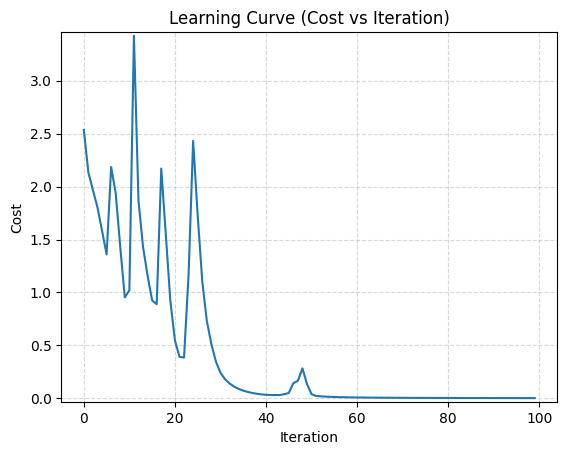

In [ ]:
import matplotlib.pyplot as plt

a = np.min(costs)
b = np.max(costs)
pad = (b - a) * 0.01  # 10% padding

plt.plot(costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Learning Curve (Cost vs Iteration)")
plt.ylim(a - pad, b + pad)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

예측 결과를 확인하기 위한 코드

Accuracy: 1.0

Classification Report:

              precision  recall  f1-score  support
0                   1.0     1.0       1.0     14.0
1                   1.0     1.0       1.0     10.0
2                   1.0     1.0       1.0      6.0
3                   1.0     1.0       1.0      9.0
4                   1.0     1.0       1.0     18.0
5                   1.0     1.0       1.0     14.0
6                   1.0     1.0       1.0      6.0
7                   1.0     1.0       1.0     13.0
8                   1.0     1.0       1.0      5.0
9                   1.0     1.0       1.0      5.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    100.0
weighted avg        1.0     1.0       1.0    100.0

Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0 

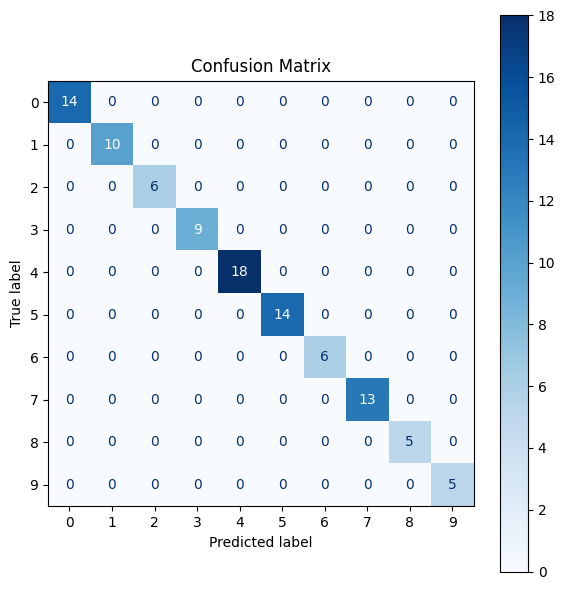

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------
# 1️⃣ 예측값 생성 (softmax / logits 공용)
# Z_best: (C, N)
# ----------------------------------
y_pred = np.argmax(Z_best, axis=0)   # (N,)
y_true = y                           # (N,)

# ----------------------------------
# 2️⃣ 정확도
# ----------------------------------
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# ----------------------------------
# 3️⃣ Classification Report (DataFrame)
# ----------------------------------
report_df = pd.DataFrame(
    classification_report(y_true, y_pred, output_dict=True)
).T

print("\nClassification Report:\n")
print(report_df)

# ----------------------------------
# 4️⃣ Confusion Matrix
# ----------------------------------
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=ax, values_format="d")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
